In [1]:
from utils import load_buffers,load_task_markers
import pandas as pd
import config
import os
import numpy as np

import mne
from mne import create_info
from mne.epochs import EpochsArray
from mne.decoding import Vectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt

import pickle
%matplotlib qt

In [2]:
# Loading files and forming the initial DataFrames
file_path = 'processed_data/motor_imagery/2024-08-10_14-19-00/task_data/task_markers.npz'  # Replace with your file path
df_tasks = load_task_markers(file_path)

folder_path = 'processed_data/motor_imagery/2024-08-10_14-19-00/signal_data/'
df_buffers = load_buffers(folder_path)

df_buffers = df_buffers.sort_values('timestamps').reset_index(drop=True)
df_tasks = df_tasks.sort_values('timestamps').reset_index(drop=True)

# Extracting data for the relevant channels
relevant_channels = 8  # For example, using 8 channels
df_buffers_raw = df_buffers.iloc[:, :relevant_channels] 

# Renaming the columns
channel_names = ['FP1', 'FP2', 'C3', 'C4', 'FC1', 'FC2', 'CP1', 'CP2']
df_buffers_raw.columns = channel_names

# Adding a column with timestamps
df_buffers_raw['timestamps'] = df_buffers['timestamps']

# Displaying the updated DataFrame
df_buffers_raw.head()


Array names in the .npz file: ['event_ids', 'timestamps']


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,141487.234375,173610.484375,18832.394531,30951.332031,15533.389648,35950.992188,30830.878906,36048.625000,2387.735521
1,141510.843750,173649.765625,18809.730469,30946.347656,15486.831055,35970.839844,30889.328125,36231.238281,2387.738514
2,141478.296875,173722.140625,18865.722656,31017.984375,15453.347656,35936.488281,30432.324219,36009.308594,2387.742479
3,141448.671875,173712.812500,18886.687500,31034.972656,15483.544922,35925.667969,30325.863281,35877.925781,2387.746514
4,141444.250000,173650.437500,18869.812500,31006.763672,15495.414062,35892.453125,30459.794922,35806.957031,2387.750569


In [3]:
df_markers = df_tasks[df_tasks['event_ids'].isin([1,2,3,4,99,100])]

markers_map = {
            1 :'left_start',
            2: 'left_end',
            3:'right_start',
            4:'right_end',
            99:'rest_start',
            100:'rest_end'
}

# Initialize lists for onsets, durations, and descriptions
onsets = []
durations = []
descriptions = []

# Create a dictionary to keep track of start times
start_times = {}

# Iterate over the DataFrame rows
for index, row in df_markers.iterrows():
    event_id = row['event_ids']
    timestamp = row['timestamps']

    if event_id in markers_map:
        description = markers_map[event_id]

        # Check if it is a start event
        if 'start' in description:
            # Store the start time
            start_times[description.split('_')[0]] = timestamp
        elif 'end' in description:
            # Determine the corresponding start event type
            event_type = description.split('_')[0]  # e.g., 'left', 'right', 'rest'
            
            if event_type in start_times:
                start_time = start_times[event_type]
                duration = timestamp - start_time
                
                # Append to lists
                onsets.append(start_time)
                durations.append(duration)
                descriptions.append(event_type.upper())
                # Remove the start time to avoid re-use
                del start_times[event_type]

# Print the results
print("Onsets:", onsets)
print("Durations:", durations)
print("Descriptions:", descriptions)

Onsets: [2388.1268703, 2391.1514595, 2392.1847854, 2395.2182474, 2396.2515675, 2399.2852377, 2400.3185931, 2403.3519229, 2404.3852416, 2407.4186044, 2408.4519715, 2411.4853094]
Durations: [3.0081320999997843, 1.0176900999999816, 3.0175027000000227, 1.0174855000000207, 3.017221099999915, 1.0175076999998964, 3.01794050000035, 1.0179824000001645, 3.0180300000001807, 1.0178900000000795, 3.0177836999996543, 1.0179549999998017]
Descriptions: ['LEFT', 'REST', 'RIGHT', 'REST', 'LEFT', 'REST', 'RIGHT', 'REST', 'LEFT', 'REST', 'RIGHT', 'REST']


In [4]:
# Creating separate DataFrames for each event
left_events = []
right_events = []
rest_events = []
# Iterating through onsets, durations, and descriptions, creating a DataFrame for each event
for onset, duration, description in zip(onsets, durations, descriptions):
    event_df = df_buffers_raw[(df_buffers_raw['timestamps'] >= onset) & (df_buffers_raw['timestamps'] <= (onset + duration))]
    
    if description == 'LEFT':
        left_events.append(event_df)
    elif description == 'RIGHT':
        right_events.append(event_df)
    elif description == 'REST':
        rest_events.append(event_df)

# Displaying the first few DataFrames for verification
for i, df in enumerate(left_events[:3]):
    print(f"Left Event {i+1} DataFrame:")
    display(df)

for i, df in enumerate(right_events[:3]):
    print(f"Right Event {i+1} DataFrame:")
    display(df)
    # spectrum = df.compute_psd()

# for i, df in enumerate(rest_events[:3]):
#     print(f"Rest Event {i+1} DataFrame:")
#     display(df)


Left Event 1 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
99,141452.750000,173709.062500,18881.681641,31004.462891,15485.244141,35893.750000,30435.275391,35793.191406,2388.130633
100,141487.093750,173667.515625,18844.398438,30961.189453,15529.366211,35951.929688,30786.800781,36002.042969,2388.134519
101,141521.453125,173698.265625,18815.988281,30943.597656,15498.341797,35992.859375,30936.267578,36246.574219,2388.137578
102,141474.515625,173757.609375,18854.433594,30994.449219,15438.439453,35942.679688,30477.921875,36041.605469,2388.141581
103,141446.890625,173757.234375,18888.318359,31018.857422,15468.122070,35930.316406,30319.046875,35887.378906,2388.146510
...,...,...,...,...,...,...,...,...,...
847,141610.078125,173851.718750,18820.750000,30966.062500,15529.634766,36012.214844,30951.197266,36290.628906,2391.118908
848,141557.062500,173901.828125,18857.585938,31015.125000,15468.166992,35961.140625,30501.503906,36097.933594,2391.121936
849,141536.125000,173903.515625,18902.871094,31051.916016,15504.085938,35955.441406,30345.197266,35940.218750,2391.124971
850,141537.750000,173847.359375,18893.013672,31030.324219,15518.660156,35921.308594,30451.927734,35847.304688,2391.129925


Left Event 2 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
2133,141534.703125,173879.765625,18765.607422,30905.220703,15510.009766,35933.222656,30823.369141,36109.042969,2396.254045
2134,141545.500000,173927.468750,18750.296875,30903.343750,15450.062500,35935.750000,30798.982422,36230.703125,2396.258953
2135,141504.328125,173979.703125,18803.382812,30960.943359,15421.117188,35895.761719,30345.376953,35996.968750,2396.262972
2136,141486.234375,173964.453125,18825.466797,30971.046875,15453.526367,35880.628906,30281.652344,35874.101562,2396.266993
2137,141488.781250,173908.625000,18807.382812,30937.853516,15468.211914,35850.656250,30439.253906,35822.695312,2396.271048
...,...,...,...,...,...,...,...,...,...
2883,141467.703125,174031.625000,18807.361328,30950.638672,15464.479492,35862.347656,30455.503906,35846.410156,2399.250372
2884,141522.593750,174017.468750,18775.041016,30915.658203,15512.468750,35944.355469,30835.929688,36123.457031,2399.254400
2885,141536.437500,174063.671875,18758.298828,30915.123047,15454.912109,35950.703125,30822.474609,36259.761719,2399.258422
2886,141487.500000,174111.468750,18802.914062,30968.722656,15420.200195,35909.417969,30370.074219,36032.152344,2399.263342


Left Event 3 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
4169,141494.343750,174248.359375,18804.142578,30971.783203,15455.203125,35882.394531,30331.183594,35919.230469,2404.387587
4170,141517.953125,174194.812500,18788.720703,30947.376953,15491.390625,35893.863281,30574.527344,35962.816406,2404.391550
4171,141566.859375,174193.171875,18743.859375,30906.494141,15512.289062,35975.175781,30934.769531,36306.855469,2404.395571
4172,141552.593750,174260.750000,18761.562500,30941.699219,15439.958984,35941.558594,30664.537109,36252.496094,2404.399610
4173,141522.546875,174307.640625,18818.470703,30998.806641,15454.287109,35930.496094,30317.458984,36049.074219,2404.403599
...,...,...,...,...,...,...,...,...,...
4919,141556.968750,174453.078125,18822.068359,31023.416016,15461.193359,35961.339844,30340.236328,36072.386719,2407.384926
4920,141552.765625,174413.328125,18821.621094,31015.101562,15476.638672,35930.472656,30393.320312,35968.718750,2407.387941
4921,141568.968750,174363.234375,18787.066406,30973.058594,15500.912109,35943.281250,30654.703125,36046.367188,2407.391900
4922,141618.031250,174372.281250,18744.261719,30930.322266,15507.774414,36010.671875,30974.578125,36366.535156,2407.395922


Right Event 1 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
1114,141465.062500,173834.656250,18829.490234,30968.587891,15418.143555,35887.246094,30276.957031,35911.230469,2392.185048
1115,141462.015625,173799.203125,18834.763672,30960.943359,15438.260742,35855.015625,30321.527344,35805.101562,2392.189089
1116,141482.234375,173750.687500,18813.195312,30928.757812,15473.330078,35866.437500,30574.705078,35858.433594,2392.192111
1117,141531.140625,173751.781250,18768.960938,30890.714844,15491.055664,35947.910156,30918.273438,36200.617188,2392.196069
1118,141507.062500,173807.609375,18785.634766,30927.058594,15412.489258,35908.769531,30615.765625,36129.179688,2392.200103
...,...,...,...,...,...,...,...,...,...
1865,141492.328125,173934.859375,18816.615234,30967.179688,15431.264648,35889.125000,30289.699219,35935.480469,2395.185425
1866,141476.000000,173890.531250,18812.412109,30955.578125,15444.742188,35856.644531,30321.839844,35821.777344,2395.188462
1867,141498.328125,173840.734375,18786.841797,30921.314453,15474.045898,35866.414062,30566.324219,35866.683594,2395.192424
1868,141561.687500,173853.343750,18753.046875,30891.697266,15501.962891,35956.535156,30921.470703,36208.886719,2395.196441


Right Event 2 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
3151,141536.921875,174168.843750,18787.378906,30949.857422,15429.140625,35943.414062,30519.853516,36136.871094,2400.321089
3152,141507.031250,174176.484375,18831.992188,30989.597656,15456.455078,35931.636719,30294.392578,35965.746094,2400.325141
3153,141504.093750,174133.078125,18828.013672,30976.298828,15472.079102,35898.511719,30380.804688,35869.363281,2400.329155
3154,141533.234375,174094.187500,18795.515625,30937.429688,15511.842773,35935.414062,30694.085938,36010.179688,2400.334043
3155,141576.578125,174116.375000,18758.724609,30907.052734,15498.677734,35989.796875,30934.501953,36295.523438,2400.338077
...,...,...,...,...,...,...,...,...,...
3901,141580.750000,174179.500000,18759.974609,30924.175781,15514.971680,35992.074219,30939.910156,36350.886719,2403.316507
3902,141541.031250,174242.984375,18799.203125,30976.367188,15453.101562,35944.980469,30515.628906,36174.531250,2403.320478
3903,141499.421875,174240.234375,18826.181641,31001.175781,15470.714844,35924.238281,30303.802734,36011.433594,2403.324499
3904,141507.468750,174202.656250,18821.353516,30989.218750,15487.367188,35889.996094,30393.410156,35912.546875,2403.329408


Right Event 3 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
5187,141613.640625,174390.703125,18739.009766,30921.158203,15532.897461,35996.835938,30905.041016,36290.472656,2408.454489
5188,141618.843750,174447.296875,18738.742188,30934.457031,15467.027344,35983.714844,30777.212891,36345.656250,2408.458527
5189,141576.375000,174495.531250,18789.009766,30986.693359,15451.671875,35950.902344,30357.066406,36119.546875,2408.462545
5190,141566.984375,174458.546875,18803.404297,30992.101562,15476.347656,35927.253906,30331.160156,35990.355469,2408.467472
5191,141569.562500,174397.437500,18781.187500,30958.820312,15493.357422,35908.101562,30514.556641,35964.359375,2408.470506
...,...,...,...,...,...,...,...,...,...
5937,141600.625000,174504.656250,18771.843750,30953.544922,15508.221680,35925.378906,30559.283203,36016.460938,2411.450437
5938,141648.703125,174496.375000,18726.044922,30907.544922,15535.222656,36005.933594,30935.351562,36337.699219,2411.454452
5939,141641.703125,174557.781250,18733.824219,30933.160156,15465.126953,35981.324219,30742.097656,36340.917969,2411.458465
5940,141601.000000,174592.656250,18784.628906,30986.357422,15461.774414,35956.156250,30350.628906,36129.964844,2411.463403


In [5]:
import mne
import numpy as np
import pandas as pd

# Установка уровня журнала для вывода информации о фильтрации
mne.set_log_level('info')

# Функция для увеличения данных для устранения краевых эффектов
def mirror_padding(data, pad_len):
    return np.concatenate([data[:, pad_len-1::-1], data, data[:, :-pad_len-1:-1]], axis=1)

# Функция для фильтрации DataFrame сигналов ЭЭГ с использованием IIR фильтра и notch-фильтра для удаления сетевого шума с использованием mirror padding
def filter_eeg_data(df, sfreq, low_freq, high_freq, pad_len=256):
    # Создание объекта MNE Info для данных
    info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')

    # Преобразование DataFrame в массив NumPy
    raw_data = df[channel_names].to_numpy().T
    timestamps = df['timestamps'].to_numpy()

    # Применение mirror padding к данным
    data_padded = mirror_padding(raw_data, pad_len)

    # Создание RawArray объекта из данных
    raw = mne.io.RawArray(data_padded, info)

    # Применение полосового IIR фильтра
    raw.filter(low_freq, high_freq, method='iir')
    
    # Применение notch-фильтра для удаления сетевого шума на частоте 50 Гц
    raw.notch_filter(freqs=50.0, method='iir')

    # Удаление краевых значений после фильтрации
    filtered_data = raw.get_data()[:, pad_len:-pad_len]

    # Санитизация timestamps для соответствия отфильтрованных данных
    timestamps = timestamps[:filtered_data.shape[1]]

    # Создание DataFrame с отфильтрованными данными
    df_filtered = pd.DataFrame(data=filtered_data.T, columns=channel_names)
    df_filtered['timestamps'] = timestamps

    return df_filtered

# Частота выборки и параметры фильтрации
sfreq = 250  # частота выборки
low_freq = 8.0  # нижняя граница фильтра
high_freq = 30.0  # верхняя граница фильтра

# Применение фильтрации к событиям 'left', 'right', 'rest'
left_events_filtered = [filter_eeg_data(df, sfreq, low_freq, high_freq) for df in left_events]
right_events_filtered = [filter_eeg_data(df, sfreq, low_freq, high_freq) for df in right_events]
rest_events_filtered = [filter_eeg_data(df, sfreq, low_freq, high_freq) for df in rest_events]

# Отображение первых нескольких отфильтрованных DataFrame для верификации
for i, df in enumerate(left_events_filtered[:3]):
    print(f"Filtered Left Event {i+1} DataFrame:")
    display(df)

for i, df in enumerate(right_events_filtered[:3]):
    print(f"Filtered Right Event {i+1} DataFrame:")
    display(df)

for i, df in enumerate(rest_events_filtered[:3]):
    print(f"Filtered Rest Event {i+1} DataFrame:")
    display(df)

Creating RawArray with float64 data, n_channels=8, n_times=1265
    Range : 0 ... 1264 =      0.000 ...     5.056 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Creating RawArray with float64 data, n_channels=8, n_times=1267
    Range : 0 ... 1266 =      0.000 ...     5.064 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
-----------

,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,-4.574731,-25.250143,-0.629892,-2.629534,12.483197,-5.785004,50.906958,-12.571595,2388.130633
1,-4.885750,-19.744529,-0.470810,-1.835488,8.919647,-4.526085,36.120310,-8.279052,2388.134519
2,-5.110808,-10.925731,-0.188259,-0.701139,3.355040,-2.445594,12.811208,-1.602892,2388.137578
3,-4.753212,-2.092466,0.194321,0.180514,-1.923730,-0.207233,-9.857534,4.645337,2388.141581
4,-3.584431,3.891648,0.683137,0.450246,-5.066084,1.608327,-24.303610,8.243679,2388.146510
...,...,...,...,...,...,...,...,...,...
748,6.803560,8.972151,-1.092696,-1.364872,-0.677330,7.517687,15.912668,31.776801,2391.118908
749,4.369981,3.352873,3.108526,0.188660,2.756075,5.184754,8.765399,13.619531,2391.121936
750,0.282247,-4.187047,8.264474,2.704112,7.489250,1.541969,-2.629603,-13.653898,2391.124971
751,-3.990417,-11.395354,13.028620,5.280567,12.124927,-2.221982,-14.466824,-41.248427,2391.129925


Filtered Left Event 2 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,16.140871,-6.140095,-12.380725,-5.962042,8.229056,24.680432,109.409176,81.610628,2396.254045
1,12.507861,-3.323468,-8.723147,-4.102828,6.256884,18.438421,77.889887,58.519497,2396.258953
2,6.569572,0.966706,-2.910445,-1.420025,3.111701,8.297420,28.082243,21.957600,2396.262972
3,0.305147,4.734098,2.839531,0.670658,-0.015605,-2.203263,-20.506843,-13.922376,2396.266993
4,-4.583005,6.345069,6.675466,1.237144,-2.136985,-9.944074,-51.796219,-37.429794,2396.271048
...,...,...,...,...,...,...,...,...,...
750,-4.361791,-16.596461,-6.867661,-11.498685,0.224716,-7.773515,29.958477,-2.242862,2399.250372
751,-3.358656,-8.609846,-4.463058,-6.925256,-2.521057,-6.230195,11.039669,-1.819949,2399.254400
752,-2.138534,3.583934,-0.852567,-0.044793,-6.595423,-3.727939,-18.868505,-1.513364,2399.258422
753,-1.151847,15.824087,2.719262,6.795886,-10.786666,-1.245379,-49.775662,-1.348297,2399.263342


Filtered Left Event 3 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,-12.405620,-24.061135,-7.415133,-10.678763,-3.091388,-20.859117,-10.727516,-51.795176,2404.387587
1,-8.953369,-18.332831,-6.213900,-8.243357,-3.315465,-16.111794,-8.213149,-36.992560,2404.391550
2,-3.295530,-8.866676,-3.959279,-4.080847,-3.297047,-8.183205,-4.008447,-13.396537,2404.395571
3,2.591428,1.236318,-1.000643,0.631925,-2.493957,0.454378,0.504209,10.007677,2404.399610
4,6.809915,9.038119,2.067135,4.613792,-0.758553,7.414706,4.003219,25.596304,2404.403599
...,...,...,...,...,...,...,...,...,...
750,-3.659581,4.815459,12.554614,16.013764,6.799007,3.241907,-42.924745,-26.269306,2407.384926
751,-1.210988,3.608677,7.832687,10.862311,5.252180,4.937608,-13.816588,-5.562295,2407.387941
752,3.044196,0.690694,-0.170746,1.519659,2.670592,6.791584,30.363748,24.311026,2407.391900
753,7.569719,-2.761010,-8.550312,-8.449153,0.080034,8.519074,75.403690,54.133907,2407.395922


Filtered Right Event 1 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,-10.444019,9.623756,10.901196,8.069619,-6.761779,-16.627245,-112.714260,-74.693566,2392.185048
1,-6.709491,5.912000,7.619490,4.835357,-4.939959,-12.447547,-80.430606,-52.489871,2392.189089
2,-1.045878,-0.038812,2.378648,-0.212174,-2.112529,-5.841089,-29.409011,-17.436787,2392.192111
3,3.941706,-5.930637,-2.867331,-4.987637,0.513271,0.606238,20.389019,16.658382,2392.196069
4,6.232515,-9.641810,-6.475573,-7.779192,1.966072,4.760835,52.508456,38.315842,2392.200103
...,...,...,...,...,...,...,...,...,...
751,-10.340518,4.974075,5.941052,7.594542,-3.531331,-7.494355,-51.428037,-30.439509,2395.185425
752,-5.117004,3.533271,1.944023,5.076058,-2.003859,-2.665827,-20.966583,-10.588872,2395.188462
753,3.539506,0.219266,-3.588864,0.651286,0.760497,4.793442,27.164884,19.728311,2395.192424
754,12.539926,-3.541202,-9.009358,-4.060453,3.730702,12.417925,76.902231,50.699951,2395.196441


Filtered Right Event 2 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,-7.715922,13.123776,5.366666,11.420272,-18.061252,-8.637979,-104.431971,-29.408210,2400.321089
1,-4.694355,9.399602,3.734475,9.029984,-13.234055,-6.323584,-74.518676,-20.962003,2400.325141
2,-0.011496,3.638791,1.105702,5.062131,-5.689745,-2.786490,-27.248897,-7.649068,2400.329155
3,4.309299,-1.749177,-1.605254,0.689693,1.484042,0.395794,18.923699,5.287388,2400.334043
4,6.553326,-4.932730,-3.651067,-3.114730,5.797816,1.979504,48.725060,13.463210,2400.338077
...,...,...,...,...,...,...,...,...,...
750,5.710224,0.172645,0.748586,1.134921,1.211293,10.076686,25.584812,35.011863,2403.316507
751,5.507649,3.341296,3.464831,3.408610,3.627911,6.395885,10.956625,14.600995,2403.320478
752,3.249841,4.660792,6.439531,6.146041,6.245496,-0.104800,-11.210254,-16.794169,2403.324499
753,0.203754,4.540061,9.074411,8.694523,8.550232,-7.009027,-33.695001,-48.826364,2403.329408


Filtered Right Event 3 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,16.861984,6.588428,-9.502358,-4.986625,9.678580,23.115375,104.134619,88.628610,2408.454489
1,14.052001,7.403283,-5.941491,-2.495586,7.886195,16.806613,74.391956,63.458384,2408.458527
2,9.293154,8.338646,-0.526836,1.234576,4.786571,6.669817,27.238639,23.540794,2408.462545
3,3.879215,8.386405,4.253046,4.409949,1.164532,-3.552828,-19.075694,-15.725554,2408.467472
4,-1.036263,6.797303,6.425746,5.673694,-2.185917,-10.587189,-49.399143,-41.534375,2408.470506
...,...,...,...,...,...,...,...,...,...
750,1.538398,-6.799574,-1.872891,-4.481238,8.197392,3.721565,43.723018,11.687354,2411.450437
751,-0.700857,-3.571469,-1.105026,-2.666738,3.493602,0.621312,16.897857,3.928749,2411.454452
752,-3.672735,2.188531,0.804444,0.925589,-3.454231,-3.507299,-24.186354,-7.125057,2411.458465
753,-6.529364,8.427252,3.079056,4.944809,-10.381305,-7.424770,-66.078343,-18.052891,2411.463403


Filtered Rest Event 1 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,10.489040,-5.919101,-6.833477,-9.282184,9.037603,11.634101,81.775601,50.401731,2391.154947
1,3.204347,-3.367213,-2.338393,-3.332949,3.658998,3.658028,29.317655,18.308312,2391.157959
2,-4.168501,-1.100429,1.578863,2.130197,-2.091951,-4.532226,-22.344208,-13.731382,2391.161942
3,-9.359806,0.017287,3.269450,5.031228,-6.708573,-10.542378,-56.587161,-35.600591,2391.165961
4,-11.344834,-0.185626,2.299639,4.711311,-9.419371,-13.293820,-66.983973,-43.087556,2391.170040
...,...,...,...,...,...,...,...,...,...
248,1.460076,-14.179121,-6.810537,-12.008614,3.337470,0.547865,54.556128,19.488061,2392.144106
249,0.216761,-14.175110,-5.684014,-9.542025,3.549073,0.925331,47.769070,19.143677,2392.149027
250,-1.764796,-9.240887,-1.798061,-3.278562,2.143552,0.547173,19.867282,10.771996,2392.153050
251,-4.377836,-0.598039,4.105784,5.521451,-0.637495,-0.594325,-23.867458,-3.898615,2392.157052


Filtered Rest Event 2 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,2.027179,13.730634,1.225489,8.574308,-11.443516,0.738230,-51.999851,1.606501,2395.220422
1,1.248634,5.429850,0.323579,2.849248,-4.021569,1.023024,-17.247212,3.393677,2395.224443
2,-0.048145,-2.932388,-0.421141,-3.221815,3.039488,0.842264,16.590751,4.542864,2395.228456
3,-1.692308,-8.864724,-0.701937,-7.856821,7.324017,0.001713,38.232042,4.201277,2395.232483
4,-3.210600,-11.409667,-0.477877,-9.983435,8.098959,-1.245510,43.458558,2.309726,2395.237414
...,...,...,...,...,...,...,...,...,...
248,-1.839170,2.576102,-1.882166,1.362810,-7.890942,1.593805,-7.143489,19.931532,2396.210998
249,-0.534869,5.053683,-0.471303,3.012817,-6.202208,2.458153,-5.687766,17.200849,2396.215017
250,0.833864,5.097696,1.410222,4.448646,-1.493432,2.840811,-1.309518,7.076269,2396.219020
251,1.998190,2.719736,3.550007,5.593623,5.424606,2.698795,5.220325,-8.570199,2396.223980


Filtered Rest Event 3 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,-5.912594,-5.019718,3.149719,1.862965,0.725291,-10.757766,-38.015853,-48.345358,2399.286409
1,-2.263923,-1.621749,-0.120448,-1.338197,-1.012157,-5.375891,-15.238779,-19.832959,2399.291324
2,1.380603,1.934783,-3.200419,-4.197360,-2.514537,0.102161,7.133771,8.488849,2399.295344
3,3.892352,4.517959,-4.942043,-5.459268,-3.076789,4.140889,22.013109,27.801748,2399.299381
4,4.802549,5.425527,-4.860297,-4.592477,-2.407677,6.214246,26.837557,34.738234,2399.302415
...,...,...,...,...,...,...,...,...,...
248,-10.319991,-5.360694,3.223602,6.037241,-3.382131,-9.134798,-50.798073,-39.031494,2400.278046
249,-9.360676,-5.441461,3.671065,5.631461,-2.313775,-7.744747,-43.658813,-35.270041,2400.282082
250,-5.045637,-3.821716,1.871704,3.039971,-0.950318,-3.130452,-17.413577,-16.087682,2400.285105
251,1.648743,-1.246291,-1.866737,-1.222717,0.422145,3.776620,23.018229,14.836327,2400.289065


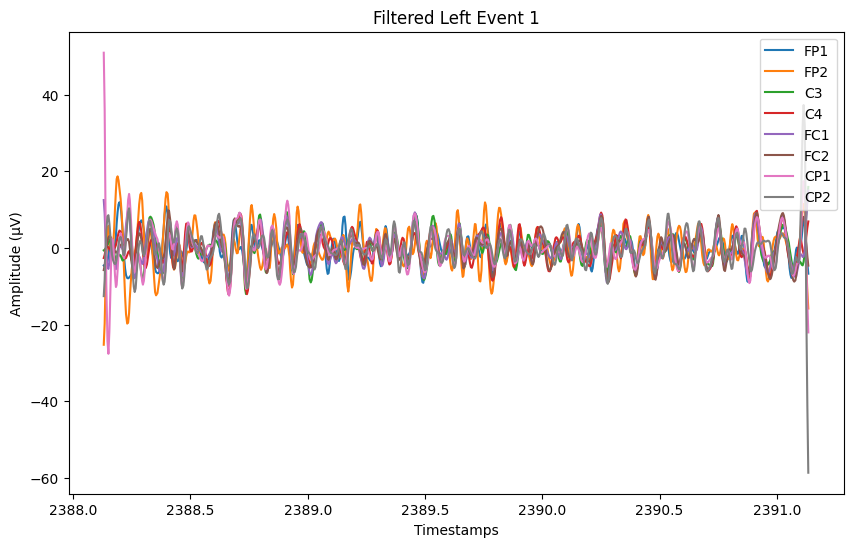

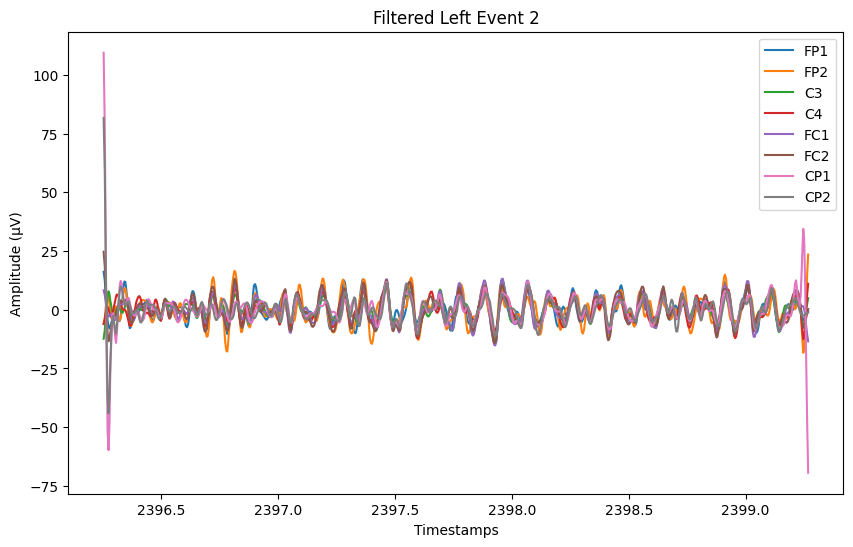

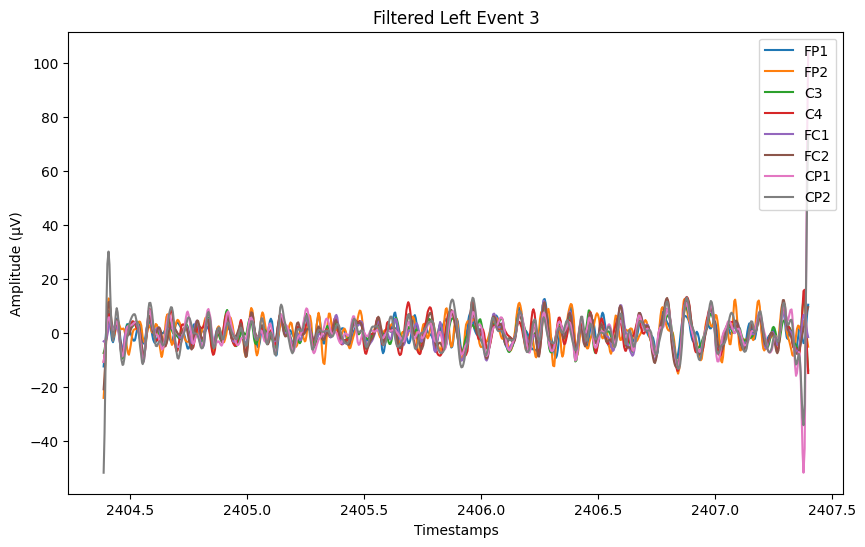

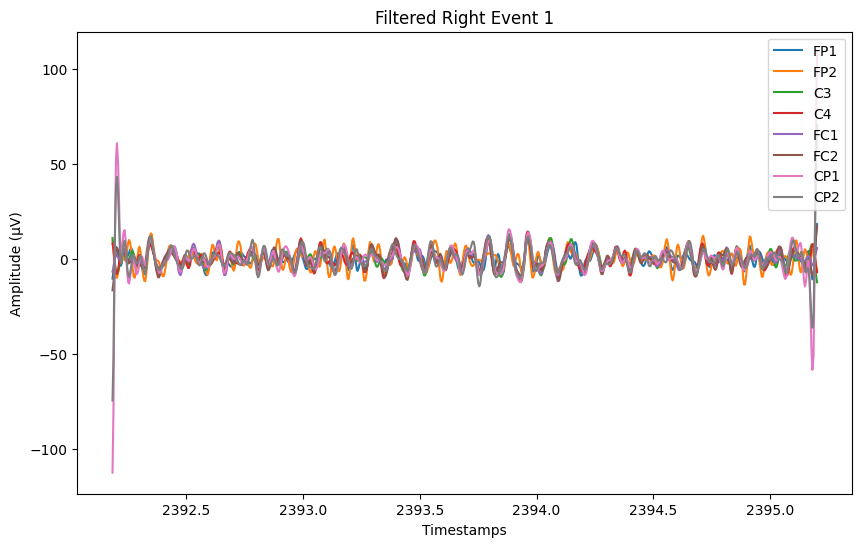

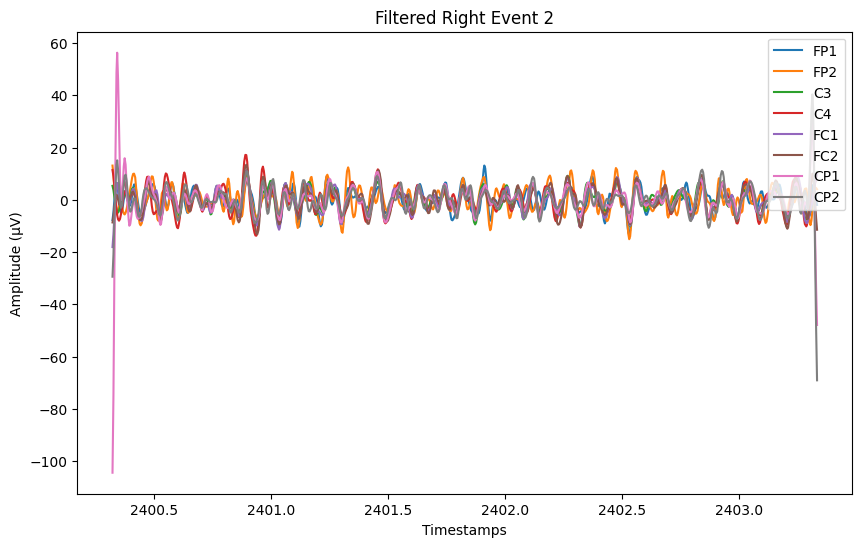

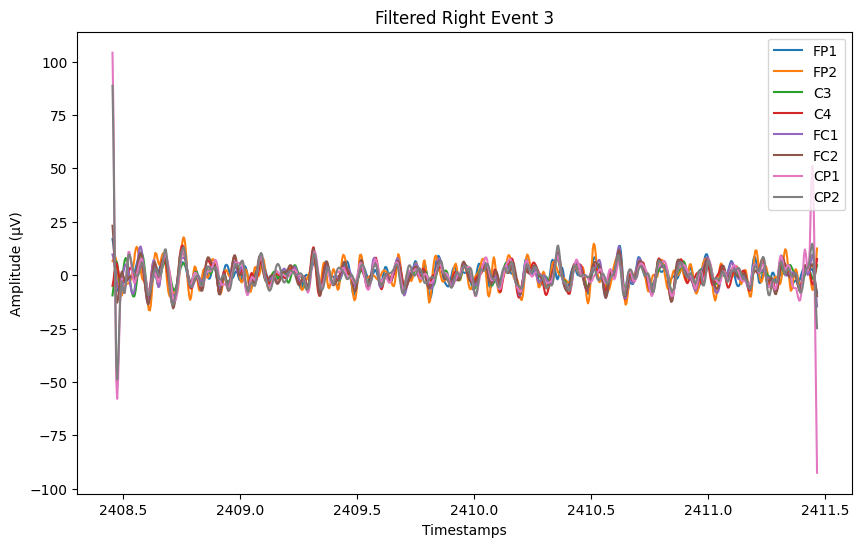

In [6]:
import matplotlib.pyplot as plt

# Включение отображения графиков в Jupyter Notebook
%matplotlib inline

# Функция для отрисовки данных ЭЭГ
def plot_eeg_data(df, title):
    plt.figure(figsize=(10, 6))  # Уменьшение размера графика
    for channel in channel_names:
        plt.plot(df['timestamps'], df[channel], label=channel)
    plt.xlabel('Timestamps')
    plt.ylabel('Amplitude (μV)')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

# Отрисовка первых нескольких отфильтрованных DataFrame для верификации и рисование графиков
for i, df in enumerate(left_events_filtered[:3]):
    plot_eeg_data(df, title=f"Filtered Left Event {i+1}")

for i, df in enumerate(right_events_filtered[:3]):
    plot_eeg_data(df, title=f"Filtered Right Event {i+1}")

#for i, df in enumerate(rest_events_filtered[:3]):
   # plot_eeg_data(df, title=f"Filtered Rest Event {i+1}")

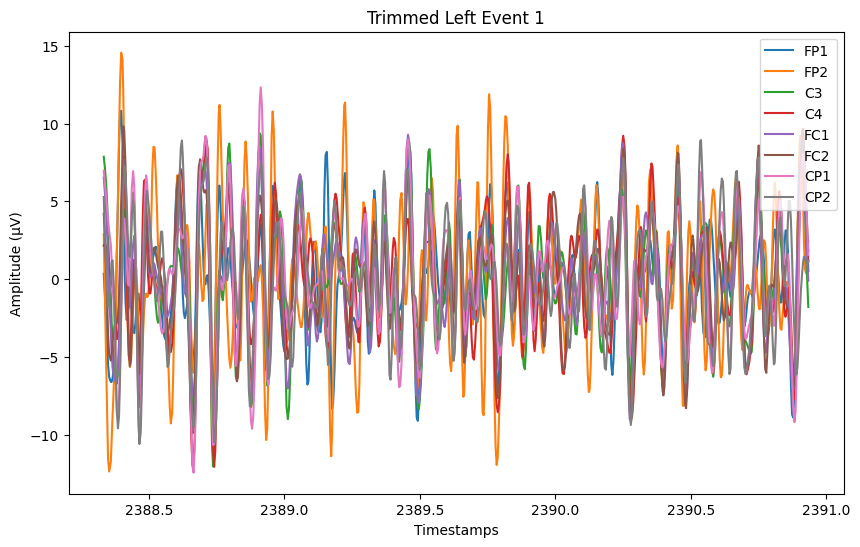

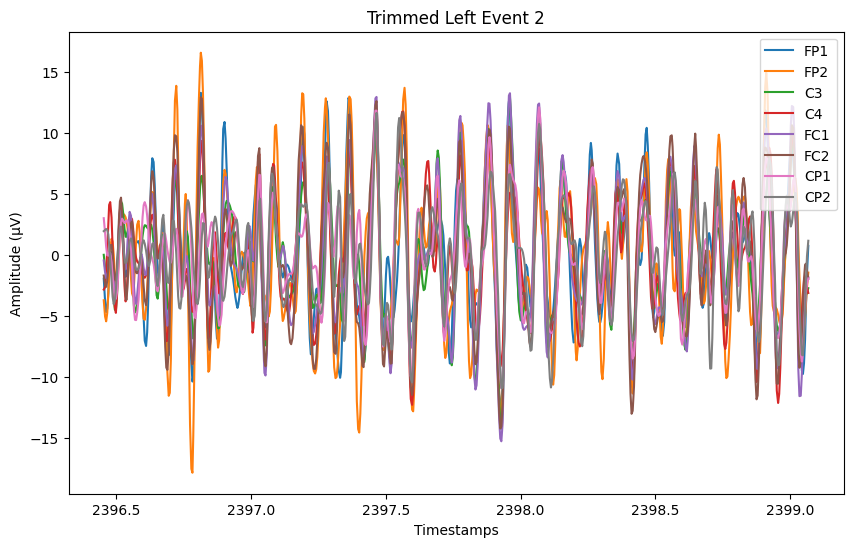

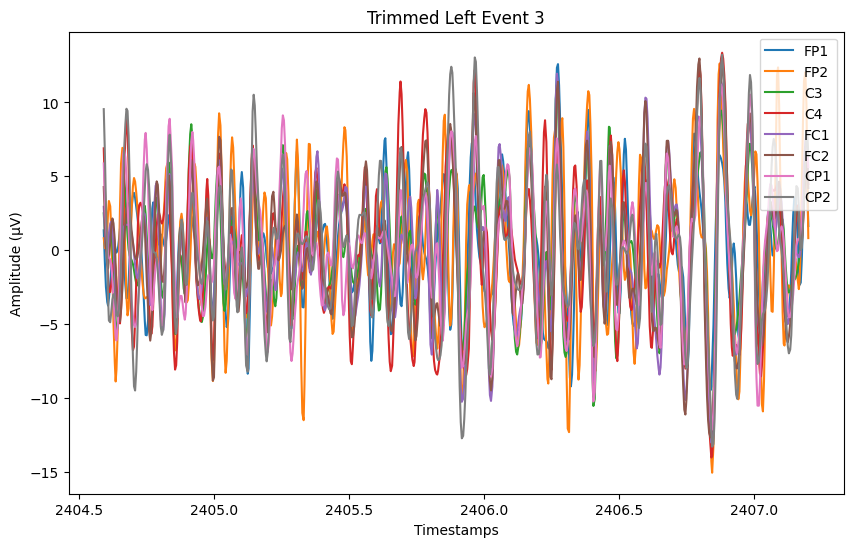

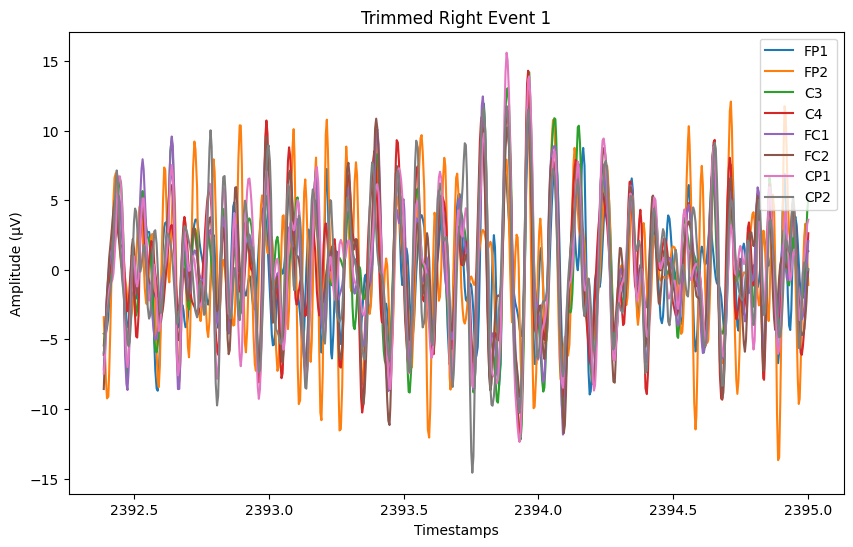

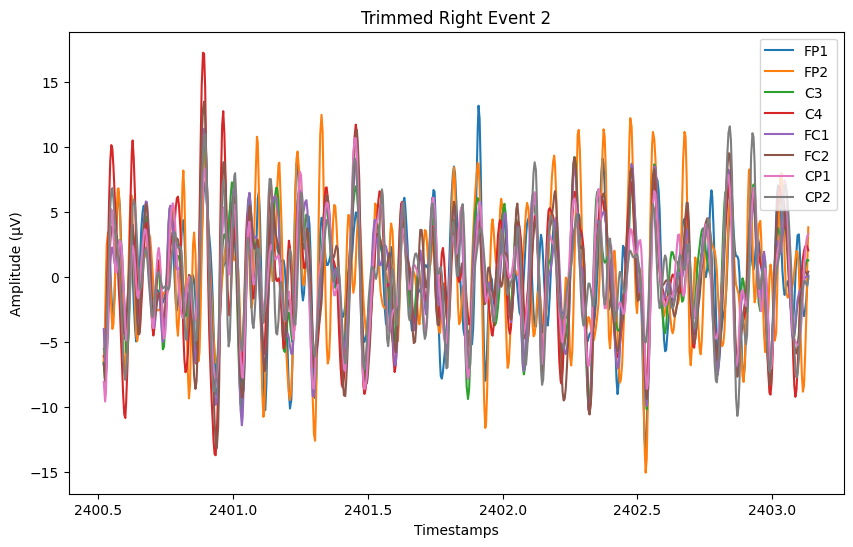

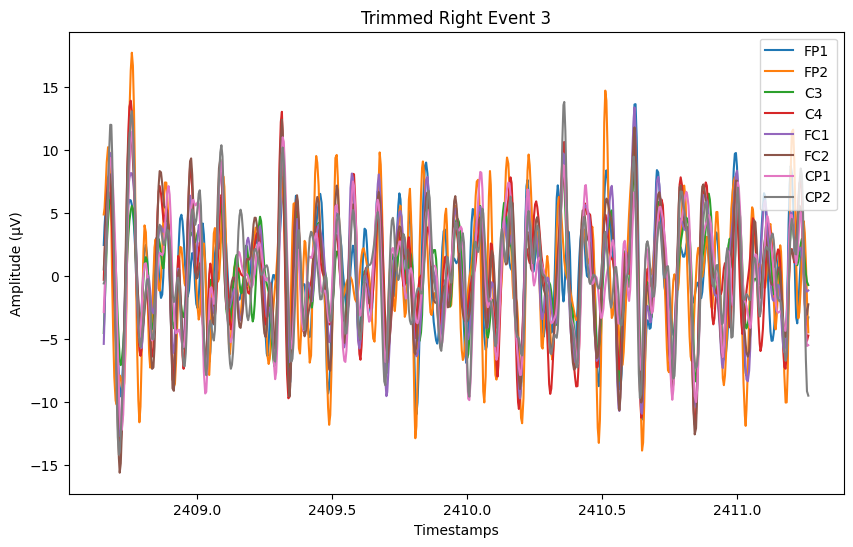

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Включение отображения графиков в Jupyter Notebook
%matplotlib inline

# Определение функции для обрезки данных ЭЭГ
def trim_eeg_data(df, trim_duration=0.2):
    timestamps = df['timestamps'].values

    # Определяем границы для обрезки
    start_time = timestamps[0] + trim_duration
    end_time = timestamps[-1] - trim_duration

    # Находим индексы для обрезки
    start_idx = np.searchsorted(timestamps, start_time)  # Индекс начала
    end_idx = np.searchsorted(timestamps, end_time)  # Индекс конца

    # Создаем новый DataFrame с обрезанными данными
    trimmed_df = df.iloc[start_idx:end_idx].reset_index(drop=True)
    return trimmed_df

# Обрезка данных и замена содержимого существующих датафреймов
left_events_filtered_trimmed = []
right_events_filtered_trimmed = []

# Применяем обрезку к каждому DataFrame в списках и сохраняем обратно
for df in left_events_filtered:
    trimmed_df = trim_eeg_data(df)
    left_events_filtered_trimmed.append(trimmed_df)

for df in right_events_filtered:
    trimmed_df = trim_eeg_data(df)
    right_events_filtered_trimmed.append(trimmed_df)

# Обновим оригинальные списки, чтобы заменить их обрезанными данными
left_events_filtered = left_events_filtered_trimmed
right_events_filtered = right_events_filtered_trimmed

# Функция для отрисовки данных ЭЭГ
def plot_eeg_data(df, title):
    plt.figure(figsize=(10, 6))  # Уменьшение размера графика
    for channel in channel_names:
        plt.plot(df['timestamps'], df[channel], label=channel)
    plt.xlabel('Timestamps')
    plt.ylabel('Amplitude (μV)')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

# Отрисовка первых нескольких обрезанных DataFrame для верификации
for i, df in enumerate(left_events_filtered[:3]):
    plot_eeg_data(df, title=f"Trimmed Left Event {i+1}")

for i, df in enumerate(right_events_filtered[:3]):
    plot_eeg_data(df, title=f"Trimmed Right Event {i+1}")

# Вы можете добавить аналогичный код для других данных, например для rest_events_filtered

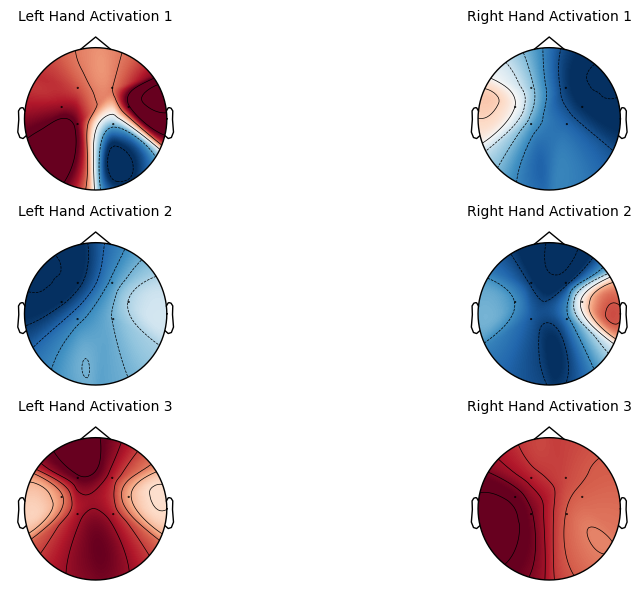

In [8]:
import matplotlib.pyplot as plt
import mne
import numpy as np

# Включение отображения графиков в Jupyter Notebook
%matplotlib inline

# Обновленный список каналов (удалены FP1 и FP2)
channel_names_subset = ['C3', 'C4', 'FC1', 'FC2', 'CP1', 'CP2']

# Создание индивидуального монтажа
montage = mne.channels.make_standard_montage('standard_1020')

# Функция для визуализации топографии ЭЭГ сигналов
def plot_topomap(data, title, sfreq=250):
    info = mne.create_info(ch_names=channel_names_subset, sfreq=sfreq, ch_types='eeg')
    evoked = mne.EvokedArray(data, info)
    evoked.set_montage(montage)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    mne.viz.plot_topomap(evoked.data.mean(axis=1), evoked.info, axes=ax, show=True, cmap='RdBu_r')
    ax.set_title(title, fontsize=10)
    plt.show()

# Количество событий
num_events = min(len(left_events_filtered), len(right_events_filtered))

# Визуализация топографии сигналов для событий левой и правой руки
fig, axes = plt.subplots(num_events, 2, figsize=(12, num_events * 2))

for i in range(num_events):
    # Левые события
    data_left = left_events_filtered[i][channel_names_subset].to_numpy().T
    info_left = mne.create_info(ch_names=channel_names_subset, sfreq=250, ch_types='eeg')
    evoked_left = mne.EvokedArray(data_left, info_left)
    evoked_left.set_montage(montage)
    mne.viz.plot_topomap(evoked_left.data.mean(axis=1), evoked_left.info, axes=axes[i, 0], show=False, cmap='RdBu_r')
    axes[i, 0].set_title(f'Left Hand Activation {i+1}', fontsize=10)

    # Правые события
    data_right = right_events_filtered[i][channel_names_subset].to_numpy().T
    info_right = mne.create_info(ch_names=channel_names_subset, sfreq=250, ch_types='eeg')
    evoked_right = mne.EvokedArray(data_right, info_right)
    evoked_right.set_montage(montage)
    mne.viz.plot_topomap(evoked_right.data.mean(axis=1), evoked_right.info, axes=axes[i, 1], show=False, cmap='RdBu_r')
    axes[i, 1].set_title(f'Right Hand Activation {i+1}', fontsize=10)

plt.tight_layout()
plt.show()

In [9]:
import os

# Specify the directory where you want to save the files
output_dir = 'D:/NEvol/filtered_events/'
os.makedirs(output_dir, exist_ok=True)

# Save filtered left events
for i, df in enumerate(left_events_filtered):
    df.drop(columns=['FP1', 'FP2'], inplace=True, errors='ignore')
    df.to_csv(os.path.join(output_dir, f'filtered_left_event_{i+1}.csv'), index=False)

# Save filtered right events
for i, df in enumerate(right_events_filtered):
    df.drop(columns=['FP1', 'FP2'], inplace=True, errors='ignore')
    df.to_csv(os.path.join(output_dir, f'filtered_right_event_{i+1}.csv'), index=False)

print("Filtered events have been saved successfully.")

Filtered events have been saved successfully.
